# Dynamical Connectivity Analysis

I will try to reproduce the dynamical FC matrices that are done in the paper Alain sent and try to make a movie out of it to make sure that it is working correctly.

In [278]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tvb_model_reference.src.nuu_tools_simulation_human as tools
from IPython.display import Image
import imageio
import os


from tvb_model_reference.simulation_file.parameter.parameter_M_Berlin import Parameter
from tvb_model_reference.view.plot_human import multiview_one, prepare_surface_regions_human
parameters = Parameter()

In [282]:
print(parameters.parameter_integrator)
print(parameters.parameter_model)

{'type': 'Heun', 'stochastic': True, 'noise_type': 'Additive', 'noise_parameter': {'nsig': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0], 'ntau': 0.0, 'dt': 0.1}, 'dt': 0.1}
{'matteo': False, 'order': 2, 'g_L': 10.0, 'E_L_e': -63.0, 'E_L_i': -65.0, 'C_m': 200.0, 'b_e': 60.0, 'a_e': 0.0, 'b_i': 0.0, 'a_i': 0.0, 'tau_w_e': 500.0, 'tau_w_i': 1.0, 'E_e': 0.0, 'E_i': -80.0, 'Q_e': 1.5, 'Q_i': 5.0, 'tau_e': 5.0, 'tau_i': 5.0, 'N_tot': 10000, 'p_connect_e': 0.05, 'p_connect_i': 0.05, 'g': 0.2, 'T': 40.0, 'P_e': [-0.0498, 0.00506, -0.025, 0.0014, -0.00041, 0.0105, -0.036, 0.0074, 0.0012, -0.0407], 'P_i': [-0.0514, 0.004, -0.0083, 0.0002, -0.0005, 0.0014, -0.0146, 0.0045, 0.0028, -0.0153], 'external_input_ex_ex': 0.000315, 'external_input_ex_in': 0.0, 'external_input_in_ex': 0.000315, 'external_input_in_in': 0.0, 'tau_OU': 5.0, 'weight_noise': 0.0001, 'K_ext_e': 400, 'K_ext_i': 0, 'initial_condition': {'E': [0.0, 0.0], 'I': [0.0, 0.0], 'C_ee': [0.0, 0.0], 'C_ei': [0.0, 0.0], 'C_ii': [0.0, 0.0], 'W_e

In [270]:
# Load AI and UD from original sets of values
folder_root = '/media/master/Nuevo vol/Internship/Data/hpc_tvbadex/results_test_DMN/results_seeds/'
label_sim = '_b_0_s_20/'
file_name = folder_root + label_sim

run_sim = 5000.0
cut_transient = 2000.0

result = tools.get_result(file_name,cut_transient,run_sim)
time_s = np.array(result[0][0]*1e-3, dtype=float) #from ms to sec
FR_exc_AI = result[0][1][:,0,:]*1e3 # from KHz to Hz; Excitatory firing rate
del result

folder_root = '/media/master/Nuevo vol/Internship/Data/hpc_tvbadex/results_test_DMN/results_seeds/'
label_sim = '_b_60_s_20/'

file_name = folder_root + label_sim
result = tools.get_result(file_name,cut_transient,run_sim)
time_s = np.array(result[0][0]*1e-3, dtype=float) #from ms to sec
FR_exc_UD = result[0][1][:,0,:]*1e3 # from KHz to Hz; Excitatory firing rate
del result

Now we have loaded the time traces (which takes some time to be fair, I think this might be better optimized).

Now we have to define a Window length and sweep over the windows. A window will come after a fraction of the window.

In [261]:
movie_folder_AI = '/home/master/Desktop/tests_hpc/figures/dynamicalFC/b0/'
movie_folder_UD = '/home/master/Desktop/tests_hpc/figures/dynamicalFC/b60/'
title_movie = 'Dynamic_FC'

parameters.parameter_simulation['path_result'] = file_name

simulator = tools.init(parameters.parameter_simulation,
                      parameters.parameter_model,
                      parameters.parameter_connection_between_region,
                      parameters.parameter_coupling,
                      parameters.parameter_integrator,
                      parameters.parameter_monitor)

weight_mat = np.array(simulator.connectivity.weights)
tracts_mat = np.array(simulator.connectivity.tract_lengths)
W = 2500 # In ms
overlay_windows = 0  # Each window will overlay in 20% the previous window

W_in_idx = int(W / parameters.parameter_integrator['dt'])

In [262]:
def vectorize_mat(M):
    n, _ = M.shape  # Assuming square matrix
    
    list_points = []
    for i in range(n):
        for j in range(i):
            if j == i:
                continue
            else:
                list_points.append(M[i, j])
    vector = np.array(list_points)
    print(f'expected shape {n*(n - 1)/2}')
    print(f'shape{vector.shape}')
    return vector

In [263]:
vectorize_mat(weight_mat)

expected shape 2278.0
shape(2278,)


array([4.28046372e-05, 4.10024161e-04, 2.77359749e-03, ...,
       7.12455933e-03, 8.21351462e-02, 3.63882189e-02])

In [264]:
# Now compute and store the figures of the FCD
idx_end = W_in_idx
idx_in = 0
frame = 0
n_wind = 0
while idx_end < FR_exc_AI.shape[0]:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    FC_AI = np.corrcoef(FR_exc_AI[idx_in:idx_end, :].T)
    im = ax.imshow(FC_AI, vmin=-1, vmax=1)
    
    corr_FC_weights = np.corrcoef(FC_AI.flatten(), weight_mat.flatten())[0, 1]
    #corr_FC_weights = np.corrcoef(vectorize_mat(FC_AI), vectorize_mat(weight_mat))[0, 1]
    print(corr_FC_weights)
    
    ax.set(title=f'Corr FC with weights = {corr_FC_weights}')
    cb_ax = fig.add_axes([.91,.2,.02,.6])
    fig.colorbar(im,orientation='vertical',cax=cb_ax)
    fig.savefig(movie_folder_AI + f'/frame{frame}.png')
    plt.close()
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    FC_UD = np.corrcoef(FR_exc_UD[idx_in:idx_end, :].T)
    im = ax.imshow(FC_UD, vmin=-1, vmax=1)
    
    corr_FC_weights = np.corrcoef(FC_UD.flatten(), weight_mat.flatten())[0, 1]
    #corr_FC_weights = np.corrcoef(vectorize_mat(FC_UD), vectorize_mat(weight_mat))[0, 1]
    print(corr_FC_weights)
    
    ax.set(title=f'Corr FC with weights = {corr_FC_weights}')
    cb_ax = fig.add_axes([.91,.2,.02,.6])
    fig.colorbar(im,orientation='vertical',cax=cb_ax)
    fig.savefig(movie_folder_UD + f'/frame{frame}.png')
    plt.close()
    
    frame += 1
    idx_in += int((1 - overlay_windows) * W_in_idx)
    idx_end += int((1 - overlay_windows) * W_in_idx)
    n_wind += 1

images_AI = []
images_UD = []
for step in range(n_wind):
    filename = movie_folder_AI + f'frame{step}.png'
    images_AI.append(imageio.imread(filename))
    filename = movie_folder_UD + f'frame{step}.png'
    images_UD.append(imageio.imread(filename))
imageio.mimsave(movie_folder_AI + title_movie + '.gif', images_AI, duration=0.25)
imageio.mimsave(movie_folder_UD + title_movie + '.gif', images_UD, duration=0.25)

0.27528243660667856
0.29704621219370947


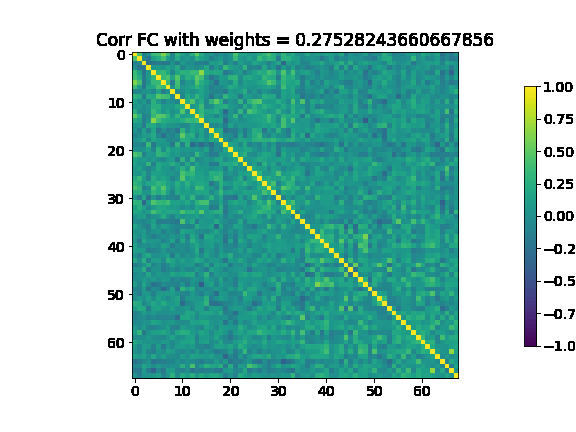

In [265]:
Image(filename=movie_folder_AI + title_movie + '.gif')

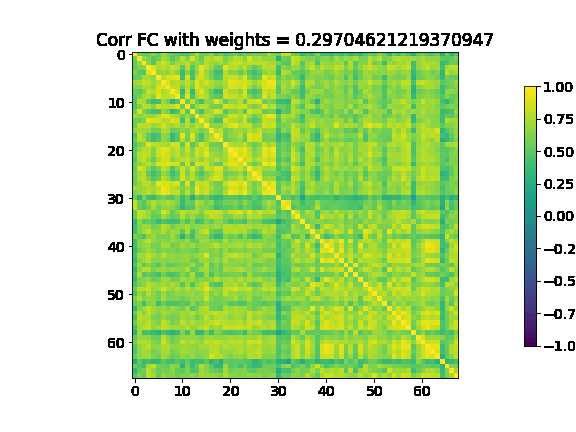

In [266]:
Image(filename=movie_folder_UD + title_movie + '.gif')

In [277]:
FC_AI = np.corrcoef(FR_exc_AI.T)
FC_UD = np.corrcoef(FR_exc_UD.T)
print(f'SC-FC correlation in AI state: {np.corrcoef(x=FC_AI.flatten(), y=weight_mat.flatten())[0, 1]*100}')
print(f'SC-FC correlation in UD state: {np.corrcoef(x=FC_UD.flatten(), y=weight_mat.flatten())[0, 1]*100}')

print(f'SC-FC correlation in AI state: {np.corrcoef(x=vectorize_mat(FC_AI), y=vectorize_mat(weight_mat))[0, 1]*100}')
print(f'SC-FC correlation in UD state: {np.corrcoef(x=vectorize_mat(FC_UD), y=vectorize_mat(weight_mat))[0, 1]*100}')

SC-FC correlation in AI state: 28.01286501354186
SC-FC correlation in UD state: 32.12306247536254
expected shape 2278.0
shape(2278,)
expected shape 2278.0
shape(2278,)
SC-FC correlation in AI state: 38.988555860837835
expected shape 2278.0
shape(2278,)
expected shape 2278.0
shape(2278,)
SC-FC correlation in UD state: 37.13903071786306


In [228]:
# Now I want to obtain the 2D histogram relating FC and normalized distance.
print(parameters.parameter_connection_between_region)
weight_mat = np.array(simulator.connectivity.weights)
tracts_mat = np.array(simulator.connectivity.tract_lengths)

print(np.sum(weight_mat, axis=0))
print(np.sum(weight_mat, axis=1))

{'default': False, 'from_file': True, 'from_h5': False, 'path': '/home/master/Desktop/tests_hpc/tvb_model_reference/simulation_file/parameter/../../data/QL_20120814/', 'number_of_regions': 0, 'tract_lengths': [], 'weights': [], 'speed': 4.0, 'normalised': True}
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.27530212 0.3330887  0.60155135 0.59212651 0.43228652 1.29672287
 1.50195432 0.87495796 0.55367875 1.73423409 1.42203741 1.36787588
 1.12054693 1.0292717  0.99973011 0.45863758 0.54119846 0.37451255
 0.47745071 0.75767934 1.05393559 0.66978905 1.50285333 1.51143718
 0.53476296 2.29217133 2.80221086 2.32869671 1.66515966 1.07354999
 0.03358049 0.23557075 0.13294441 0.97990419 0.32822794 0.3675652
 0.55342651 0.6255605  0.3802625  1.39599752 1.76173449 0.89098467
 0.45249531 1.68403242 1.27854789 1.15542523 1.1061847  1.0698

In [50]:
tracts_mat = tracts_mat / np.amax(tracts_mat)  # We "normalize the matrix"
weight_mat = weight_mat / np.amax(weight_mat)  # We "normalize the matrix"
FC_AI = np.corrcoef(FR_exc_AI.T)
FR_UD = np.corrcoef(FR_exc_UD.T)

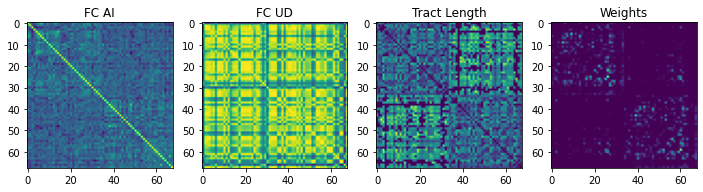

In [51]:
fig, axes = plt.subplots(1, 4, figsize=(12, 6))
axes[0].imshow(FC_AI)
axes[0].set(title='FC AI')
axes[1].imshow(FC_UD)
axes[1].set(title='FC UD')
axes[2].imshow(tracts_mat)
axes[2].set(title='Tract Length')
axes[3].imshow(weight_mat)
axes[3].set(title='Weights')
plt.show()

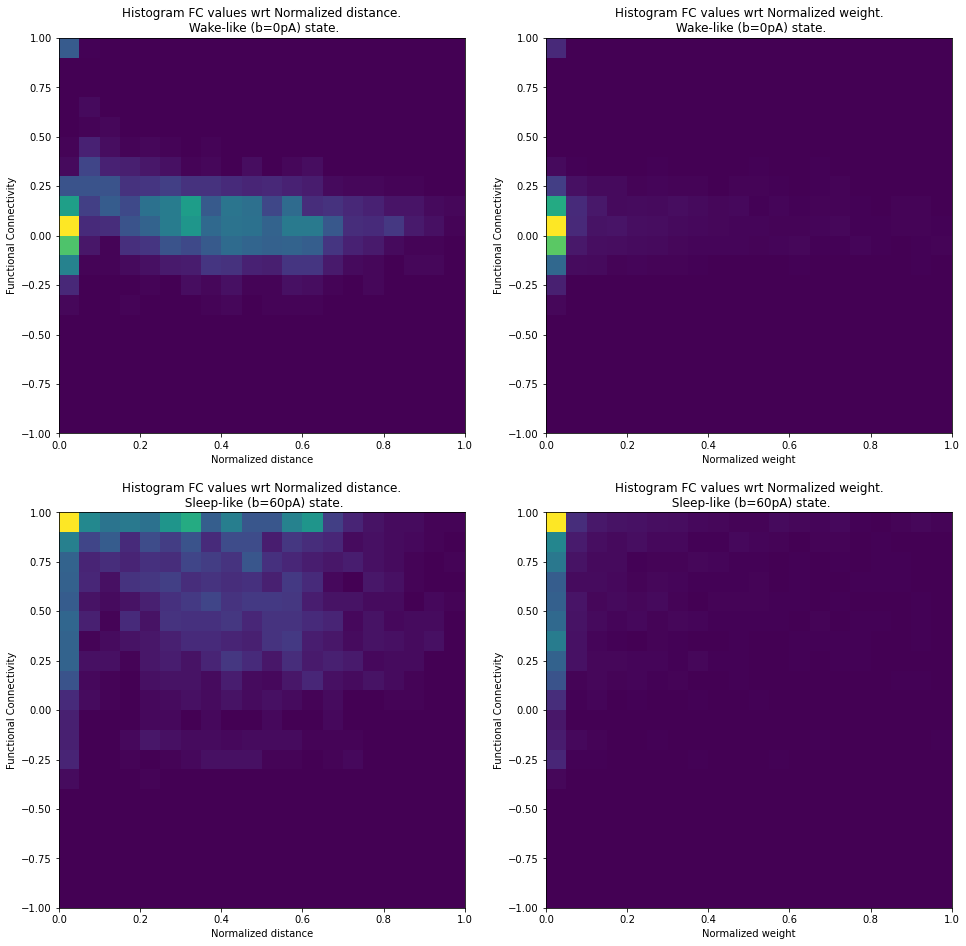

In [85]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
n_bins = 20
x_mats = [tracts_mat, weight_mat]
y_mats = [FC_AI, FC_UD]
xlabels = ['Normalized distance', 'Normalized weight']
cases = ['Wake-like (b=0pA)', 'Sleep-like (b=60pA)']

for i in range(2):
    for j in range(2):
        axes[i, j].hist2d(x_mats[j].flatten(), y_mats[i].flatten(), bins=n_bins, range=[[0, 1], [-1, 1]])
        axes[i, j].set(xlabel=xlabels[j], ylabel='Functional Connectivity', 
                       title=f'Histogram FC values wrt {xlabels[j]}.\n {cases[i]} state.')
plt.tight_layout
plt.show()

OSError: /home/master/Desktop/tests_hpc/QL_20120814_Connectivity/weights.txt not found.

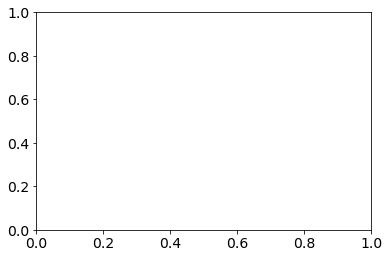

In [283]:
# Problem with the weight histograms
fig, axes = plt.subplots(1, 1)
weight_mat = np.loadtxt(conn_folder + 'weights.txt')
h = axes.hist(weight_mat.flatten(), bins=100)
plt.show()

# Possible solution: Do a similar plot as the one in inhibitory excitatory segregation. Pons Malagarriga, etc.
# We sweep by pairs in x, it's weight value in y, and then color wrt to FC. I don't actually know how useful 
# that would be.